### GAM with a spatial smoother

This notebook demostrates how to add a spatial smoother to GAM to account for spatial autocorrelation.

In [1]:
#pip install rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
#Import packages
#If any is missing, install using install.packages("xxx")
library(lattice)
library(sp)
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.


In [3]:
%%R

#Read in the data
data(meuse)
meuse$log_zinc = log(meuse$zinc)
coordinates(meuse) <- c("x", "y")

### Plotting raw data

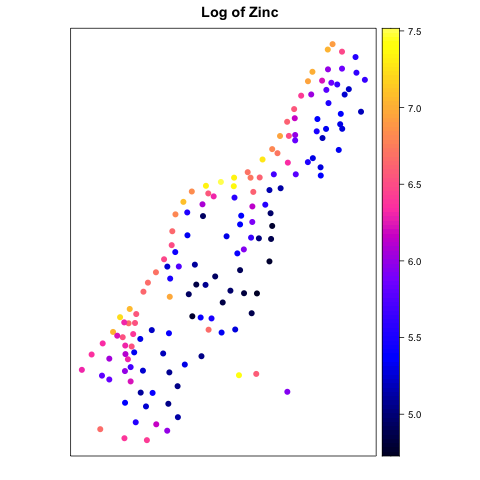

In [5]:
%%R 
spplot(meuse, "log_zinc", colorkey = TRUE, main="Log of Zinc")

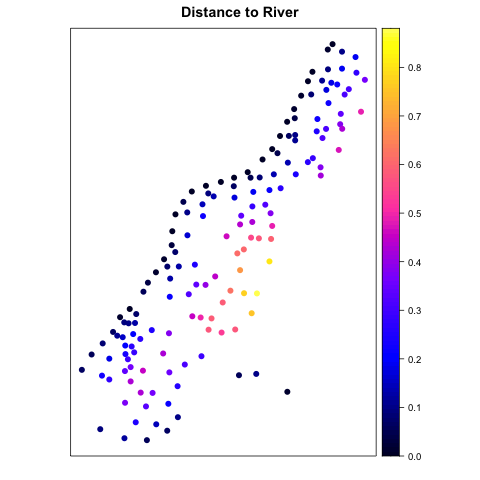

In [6]:
%%R

spplot(meuse, "dist", colorkey = TRUE, main="Distance to River")

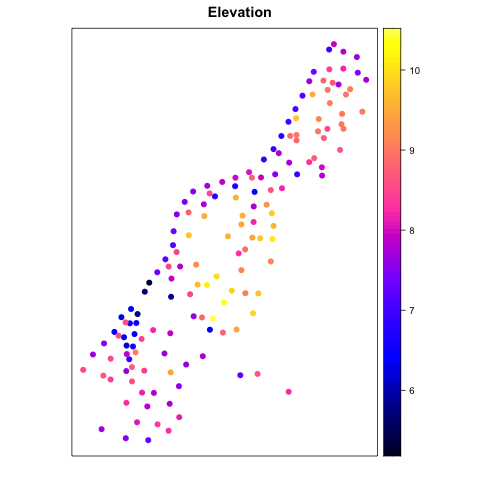

In [7]:
%%R

spplot(meuse, "elev", colorkey = TRUE, main="Elevation")

### Fitting a GAM

In [8]:
%%R

#Fit the GAM model
gam_meuse <- gam(log_zinc ~ s(x,y) + s(elev) + s(dist), data=meuse)

### GAM Results

In [9]:
%%R
#GAM results
summary(gam_meuse)


Family: gaussian 
Link function: identity 

Formula:
log_zinc ~ s(x, y) + s(elev) + s(dist)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.88578    0.02149   273.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df      F  p-value    
s(x,y)  23.143 26.526  4.571  < 2e-16 ***
s(elev)  2.007  2.527 28.984  < 2e-16 ***
s(dist)  4.098  5.097  6.665 1.48e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.863   Deviance explained = 88.9%
GCV = 0.088929  Scale est. = 0.071575  n = 155


### Visualizing GAM

There is a `scheme`parameter in `plot()` that changes the style of the spatial smoother.

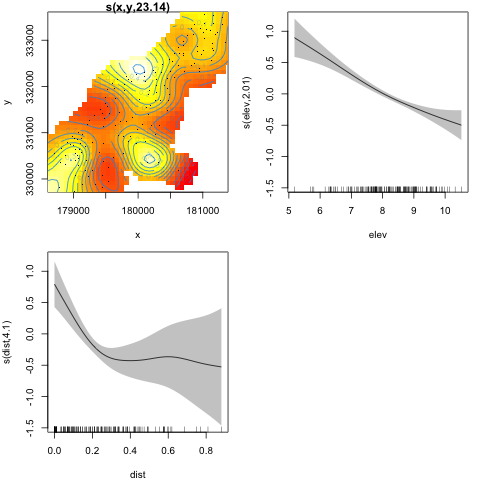

In [10]:
%%R
par(mar = c(4, 4, 1, 1))
plot(gam_meuse,scheme=2,shade=T,page=1)

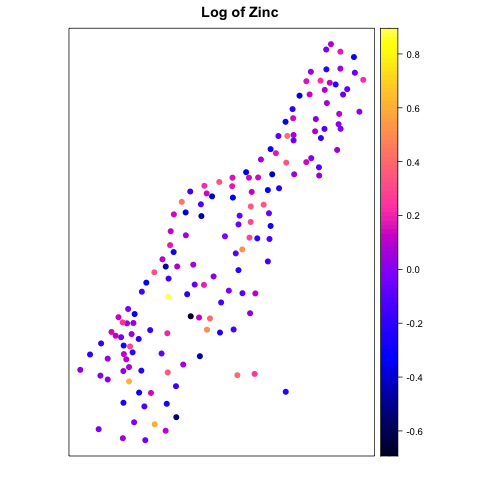

In [11]:
%%R 
meuse$gam_residuals = gam_meuse$residuals
spplot(meuse,"gam_residuals", colorkey = TRUE, main="Log of Zinc")

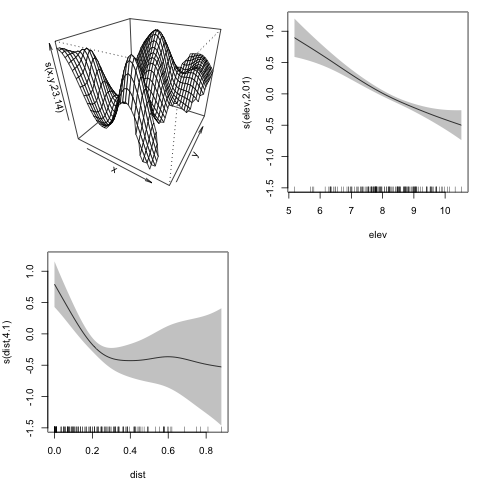

In [12]:
%%R
par(mar = c(4, 4, 1, 1))
plot(gam_meuse,scheme=1,shade=T,page=1)

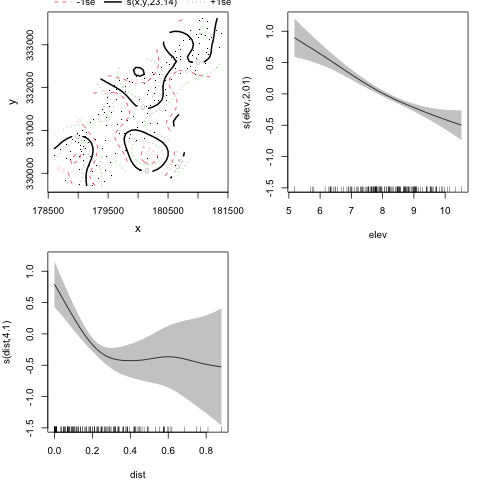

In [13]:
%%R
par(mar = c(4, 4, 1, 1))
plot(gam_meuse,scheme=0,shade=T,page=1)

### Check GAM


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 9 iterations.
The RMS GCV score gradient at convergence was 7.834529e-07 .
The Hessian was positive definite.
Model rank =  48 / 48 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value
s(x,y)  29.00 23.14    1.14    0.97
s(elev)  9.00  2.01    0.92    0.10
s(dist)  9.00  4.10    1.17    0.97


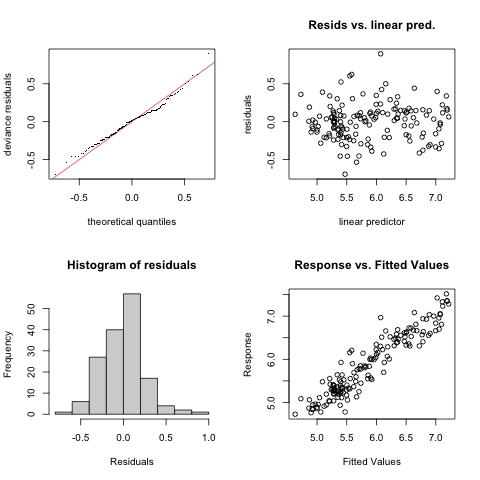

In [14]:
%%R
#Check gam
gam.check(gam_meuse)

## You can also fit spatially varying coefficient models in GAM, then GAM will have the same interpretation as an GWR/MGWR model.

In [17]:
%%R
gam_meuse2 <- gam(log_zinc ~ s(x,y) + s(x,y,by=elev) + s(x,y,by=dist), data=meuse)

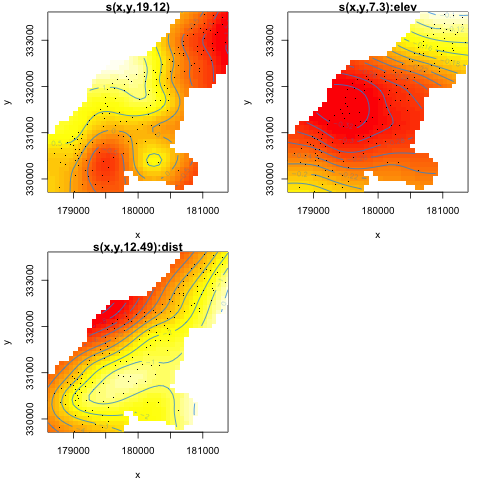

In [22]:
%%R
par(mar = c(4, 4, 1, 1))
plot(gam_meuse2,scheme=2,shade=T,page=1)

In [19]:
%%R
#GAM results
summary(gam_meuse2)


Family: gaussian 
Link function: identity 

Formula:
log_zinc ~ s(x, y) + s(x, y, by = elev) + s(x, y, by = dist)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.2928     0.3842   21.58   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
               edf Ref.df     F p-value    
s(x,y)      19.117 21.032 0.783   0.730    
s(x,y):elev  7.296  8.458 8.181  <2e-16 ***
s(x,y):dist 12.494 15.478 1.217   0.258    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.867   Deviance explained = 90.1%
GCV = 0.093367  Scale est. = 0.069328  n = 155


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran

#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [42]:
meuse = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/meuse.csv")

In [46]:
meuse.head()

,Unnamed: 0,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,log_zinc,gam_residuals,optional
0,1,181072,333611,11.7,85,299,1022,7.909,0.001358,13.6,1,1,1,Ah,50,6.929517,0.087034,True
1,2,181025,333558,8.6,81,277,1141,6.983,0.012224,14.0,1,1,1,Ah,30,7.039660,-0.036256,True
2,3,181165,333537,6.5,68,199,640,7.800,0.103029,13.0,1,1,1,Ah,150,6.461468,0.165954,True
3,4,181298,333484,2.6,81,116,257,7.655,0.190094,8.0,1,2,0,Ga,270,5.549076,-0.302885,True
4,5,181307,333330,2.8,48,117,269,7.480,0.277090,8.7,1,2,0,Ah,380,5.594711,-0.061886,True


In [45]:
meuse["log_zinc"] = np.log(meuse["zinc"])

In [73]:
variable_names = ['elev', 'dist']

y = meuse[['log_zinc']].values

X = meuse[variable_names].values

In [74]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

In [75]:
coords = meuse[['x', 'y']].values

In [76]:
mgwr_selector = Sel_BW(coords, y, X,multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Current iteration: 1 ,SOC: 0.0110792
Bandwidths: 44.0, 81.0, 44.0
Current iteration: 2 ,SOC: 0.0047771
Bandwidths: 44.0, 91.0, 44.0
Current iteration: 3 ,SOC: 0.0018567
Bandwidths: 44.0, 92.0, 44.0
Current iteration: 4 ,SOC: 0.0012353
Bandwidths: 44.0, 102.0, 44.0
Current iteration: 5 ,SOC: 0.0013688
Bandwidths: 44.0, 120.0, 44.0
Current iteration: 6 ,SOC: 0.0008103
Bandwidths: 44.0, 135.0, 44.0
Current iteration: 7 ,SOC: 0.0003863
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 8 ,SOC: 0.0001803
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 9 ,SOC: 0.0001098
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 10 ,SOC: 7.16e-05
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 11 ,SOC: 4.8e-05
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 12 ,SOC: 3.24e-05
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 13 ,SOC: 2.18e-05
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 14 ,SOC: 1.45e-05
Bandwidths: 44.0, 134.0, 44.0
Current iteration: 15 ,SOC: 9.5e-06
Bandwidths: 44.0, 134.0, 44.0


In [77]:
mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 155
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             27.943
Log-likelihood:                                                     -87.157
AIC:                                                                180.315
AICc:                                                               182.581
BIC:                                                               -738.658
R2:                                                                   0.652
Adj. R2:                                                              0.647

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Text(0.5, 1.0, 'Intercept')

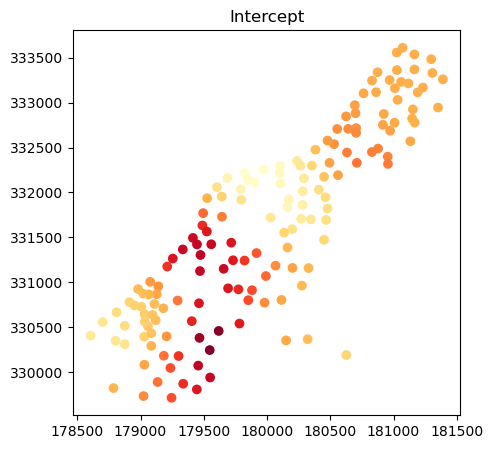

In [85]:
plt.figure(figsize=(5,5))
plt.scatter(meuse.x,meuse.y,c = mgwr_results.params[:,0],cmap="YlOrRd_r")
plt.title("Intercept")

Text(0.5, 1.0, 'Coefficients of Elev')

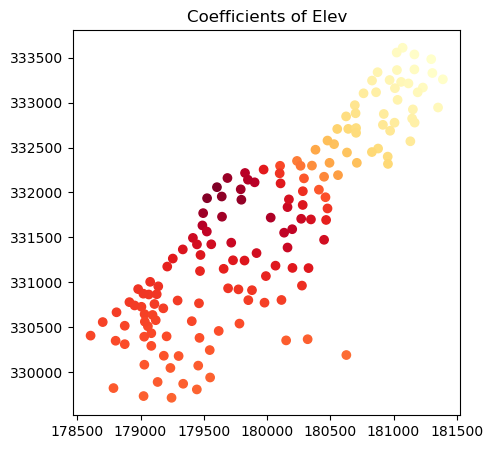

In [86]:
plt.figure(figsize=(5,5))
plt.scatter(meuse.x,meuse.y,c = mgwr_results.params[:,1],cmap="YlOrRd_r")
plt.title("Coefficients of Elev")

Text(0.5, 1.0, 'Coefficients of Dist')

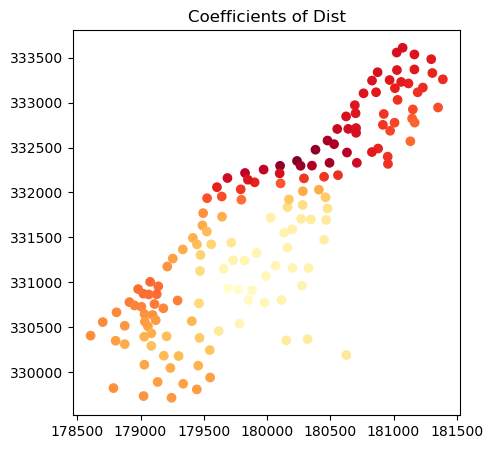

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(meuse.x,meuse.y,c = mgwr_results.params[:,2],cmap="YlOrRd_r")
plt.title("Coefficients of Dist")

If we visualize the spatially varying effect just as a 1-D function of the independent vairvale. The relationships are similar to what from GAM.

Text(0, 0.5, 'Partial effect to y')

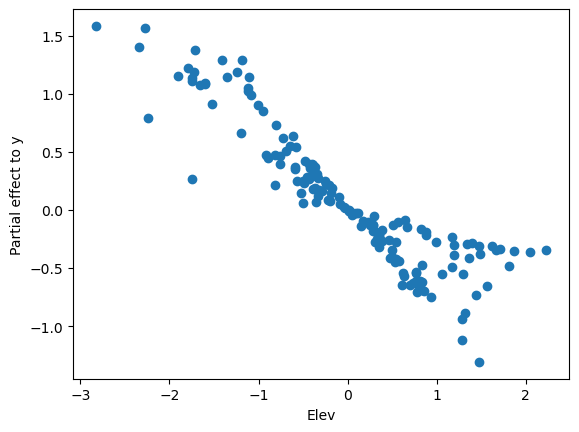

In [96]:
plt.scatter(X[:,0],mgwr_results.params[:,2]*X[:,0])
plt.xlabel("Elev")
plt.ylabel("Partial effect to y")

Text(0, 0.5, 'Partial effect to y')

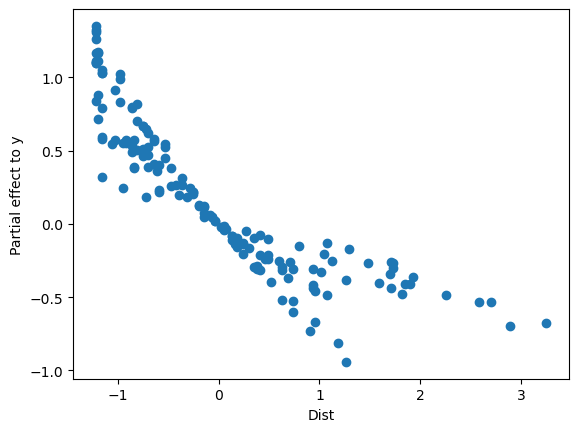

In [97]:
plt.scatter(X[:,1],mgwr_results.params[:,2]*X[:,1])
plt.xlabel("Dist")
plt.ylabel("Partial effect to y")